<a href="https://colab.research.google.com/github/kaustav1996/utility_data_analysis/blob/master/analysis_on_csv_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import os

model_errors=dict()

# ! pip install --upgrade Cython
# ! pip install --upgrade git+https://github.com/statsmodels/statsmodels
!pip install pmdarima

repo_url = 'https://github.com/kaustav1996/utility_data_analysis'

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

%ls

csv_file= os.path.abspath(os.path.join(repo_dir_path,'interval_data.csv'))

/content
fatal: destination path 'utility_data_analysis' already exists and is not an empty directory.
/content/utility_data_analysis
Already up to date.
analyze_csv_data.ipynb  interval_data.csv  LICENSE  README.md


In [122]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
#Importing data
df = pd.read_csv(csv_file)
df=df.fillna(df.mean())
#Printing head
df.head()


,TIME,KW
0,8/29/2018 0:15,0.64
1,8/29/2018 0:30,0.74
2,8/29/2018 0:45,1.10
3,8/29/2018 1:00,0.92
4,8/29/2018 1:15,0.92


In [123]:
df.tail()

,TIME,KW
16395,5/29/2019 21:00,0.67
16396,5/29/2019 21:15,0.67
16397,5/29/2019 21:30,0.67
16398,5/29/2019 21:45,0.67
16399,5/29/2019 22:00,0.67


In [125]:
train=df[7176:14471]
test=test=df[14471:]

df.Timestamp = pd.to_datetime(df['TIME'],format='%m/%d/%Y %H:%M') 



df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train['TIME'],format='%m/%d/%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test['TIME'],format='%m/%d/%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


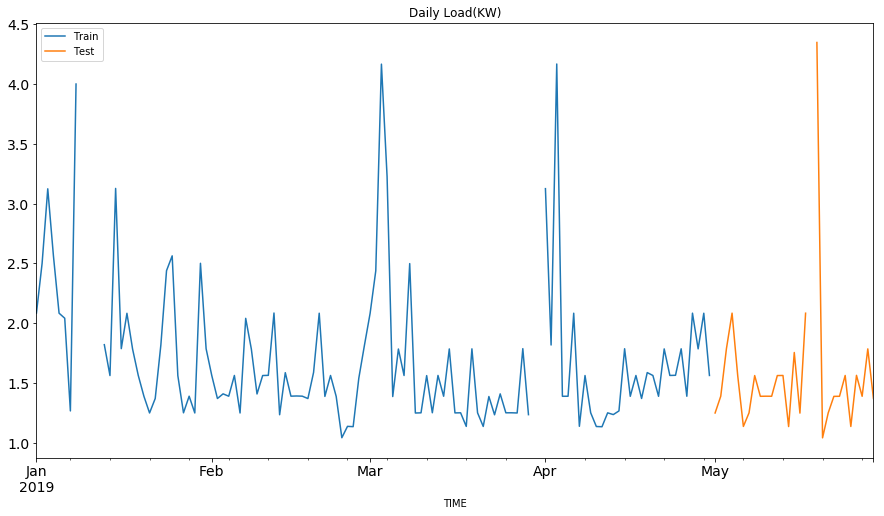

In [126]:
train.KW.plot(figsize=(15,8), title= 'Daily Load(KW)',label='Train' ,fontsize=14)
test.KW.plot(figsize=(15,8), title= 'Daily Load(KW)', label='Test', fontsize=14)
plt.legend(loc='best')
plt.show()

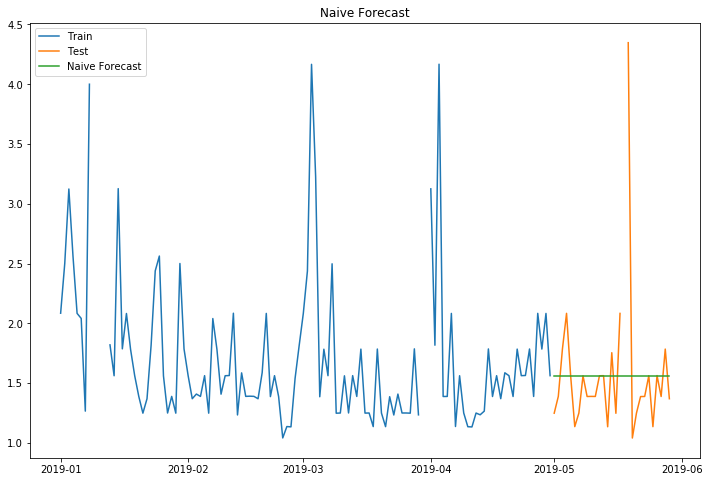

In [127]:
dd= np.asarray(train.KW)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['KW'], label='Train')
plt.plot(test.index,test['KW'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [128]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test = test.fillna(test.mean())
rms = sqrt(mean_squared_error(test.KW, y_hat.naive))
print(rms)

model_errors['Naive']=rms

0.58408790500386


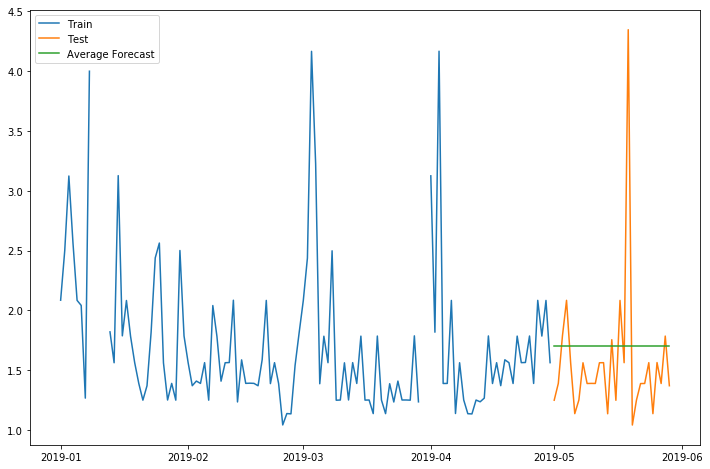

In [129]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['KW'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [130]:
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.avg_forecast))
print(rms)

model_errors['Average']=rms

0.6003961981716694


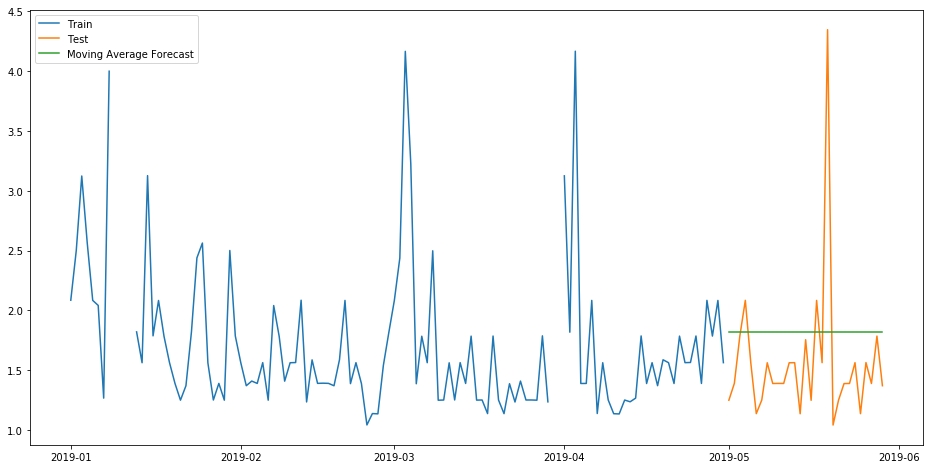

In [131]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['KW'].rolling(2).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [132]:
test = test.fillna(test.mean())
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.moving_avg_forecast))
print(rms)

model_errors['Moving Average']=rms

0.6395282981579168


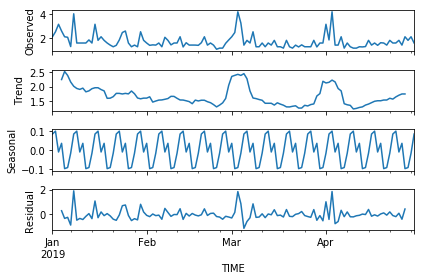

In [133]:
import statsmodels.api as sm
train = train.fillna(test.mean())
sm.tsa.seasonal_decompose(train.KW).plot()
result = sm.tsa.stattools.adfuller(train.KW)
plt.show()

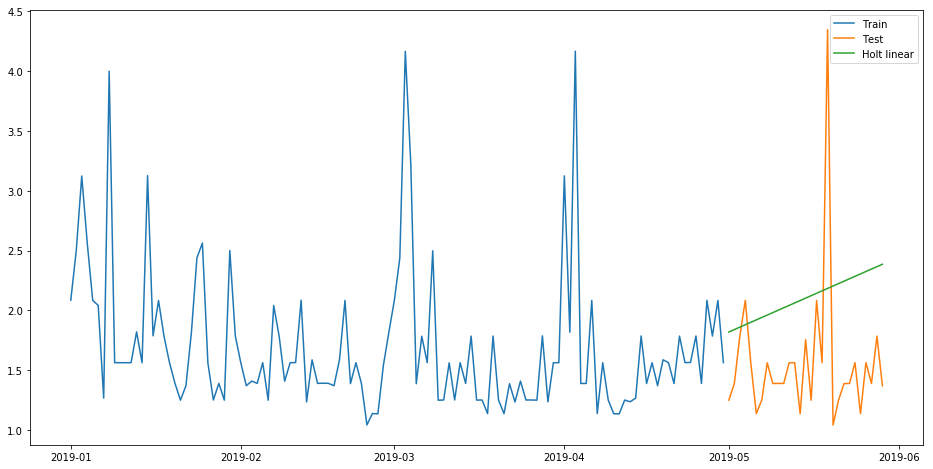

In [134]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['KW'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt linear')
plt.legend(loc='best')
plt.show()

In [135]:
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.Holt_linear))
print(rms)

model_errors['Holt Linear']=rms

0.8079147464003462


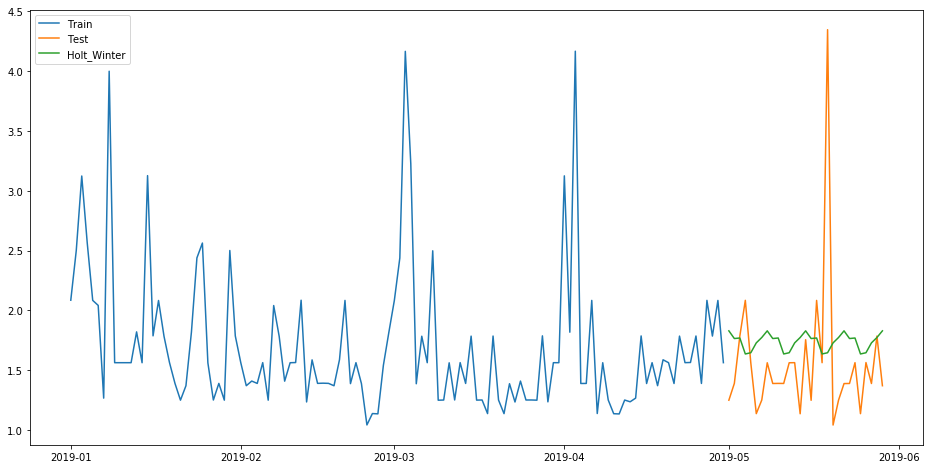

In [136]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['KW']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [137]:
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.Holt_Winter))
print(rms)

0.6311005049320109


In [138]:
import pmdarima as pm
arima = pm.auto_arima(train, error_action='ignore', trace=1,
                      seasonal=True, m=12)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=214.221, BIC=236.521, Fit time=0.966 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=217.883, BIC=223.458, Fit time=0.026 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=212.408, BIC=223.558, Fit time=0.211 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=215.555, BIC=226.705, Fit time=0.094 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=210.567, BIC=218.929, Fit time=0.061 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=212.440, BIC=223.590, Fit time=0.116 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=214.448, BIC=228.385, Fit time=0.613 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=206.961, BIC=218.111, Fit time=0.049 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=208.765, BIC=222.702, Fit time=0.139 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=210.611, BIC=227.336, Fit time=0.237 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=208.392, BIC=222.330, Fit time=0.498 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=208.477, BIC=222.415, Fit time=0.143 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=210.950, BIC=227.675, Fit time=0.748 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=208.657, BIC=222.594, Fit time=0.071 seconds
Total fit time: 3.992 seconds


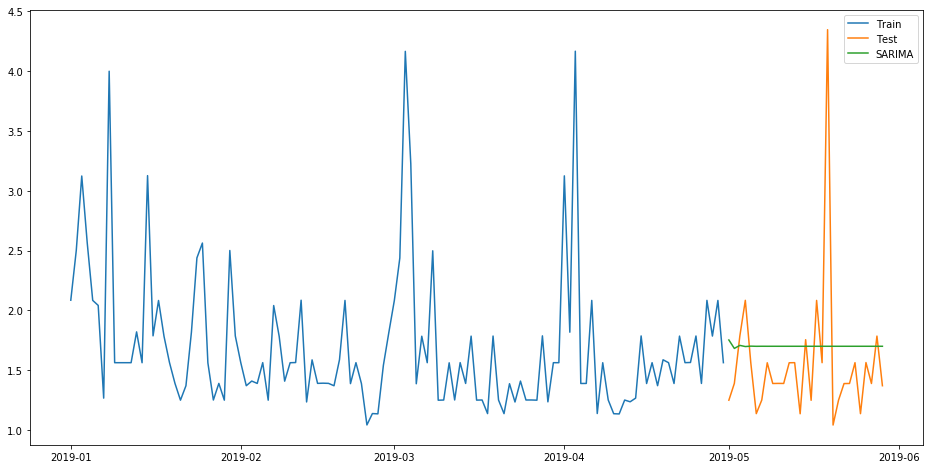

In [139]:
predicted_val=arima.predict(n_periods=test.shape[0])
predicted_df = test.copy()


for i in range(len(predicted_df)):
    predicted_df['KW'][i]=predicted_val[i]


plt.figure(figsize=(16,8))
plt.plot( train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(predicted_df, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [140]:
rms = sqrt(mean_squared_error(test.KW, predicted_df.KW))
print(rms)

model_errors['SARIMA']=rms

0.6011584520643928


In [142]:
for index in model_errors:
    print(index+' : '+str(model_errors[index]))

Naive : 0.58408790500386
Average : 0.6003961981716694
Moving Average : 0.6395282981579168
Holt Linear : 0.8079147464003462
SARIMA : 0.6011584520643928
